In [1]:
# import needed packages
%matplotlib inline
import numpy as np, matplotlib.pylab as plt, seaborn as sns, mpmath as mp, scipy.special as ss, sys, datetime
import scipy.stats as stats
sys.path.append('os.getcwd()')
import geopandas as gp, pandas as pd, urllib2
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
from pdf_ccdf import pdf_ccdf
from pdf_functions import pdf_fitter as pdf_fitter
from a_b_functions import kirchner_fitter as kirchner_fitter
from a_b_functions import getFlow as getFlow
from IRA_functions import assess_IRA as assess_IRA
import warnings
warnings.filterwarnings("ignore")
from pdf_functions import *

/Users/deale/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Kauai_discharge_txt/USGS16103000_wet.txt
Optimization terminated successfully.
         Current function value: 0.641615
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: 0.728174
         Iterations: 20
         Function evaluations: 40
Kauai_discharge_txt/USGS16103000_dry.txt
Optimization terminated successfully.
         Current function value: 0.635917
         Iterations: 56
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: 0.716312
         Iterations: 20
         Function evaluations: 40
Kauai_discharge_txt/USGS16103000_yr.txt
Optimization terminated successfully.
         Current function value: 0.635181
         Iterations: 49
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: 0.725470
         Iterations: 20
         Function evaluations: 40
Kauai_discharge_txt/USGS16117000_wet.txt
Optimiz

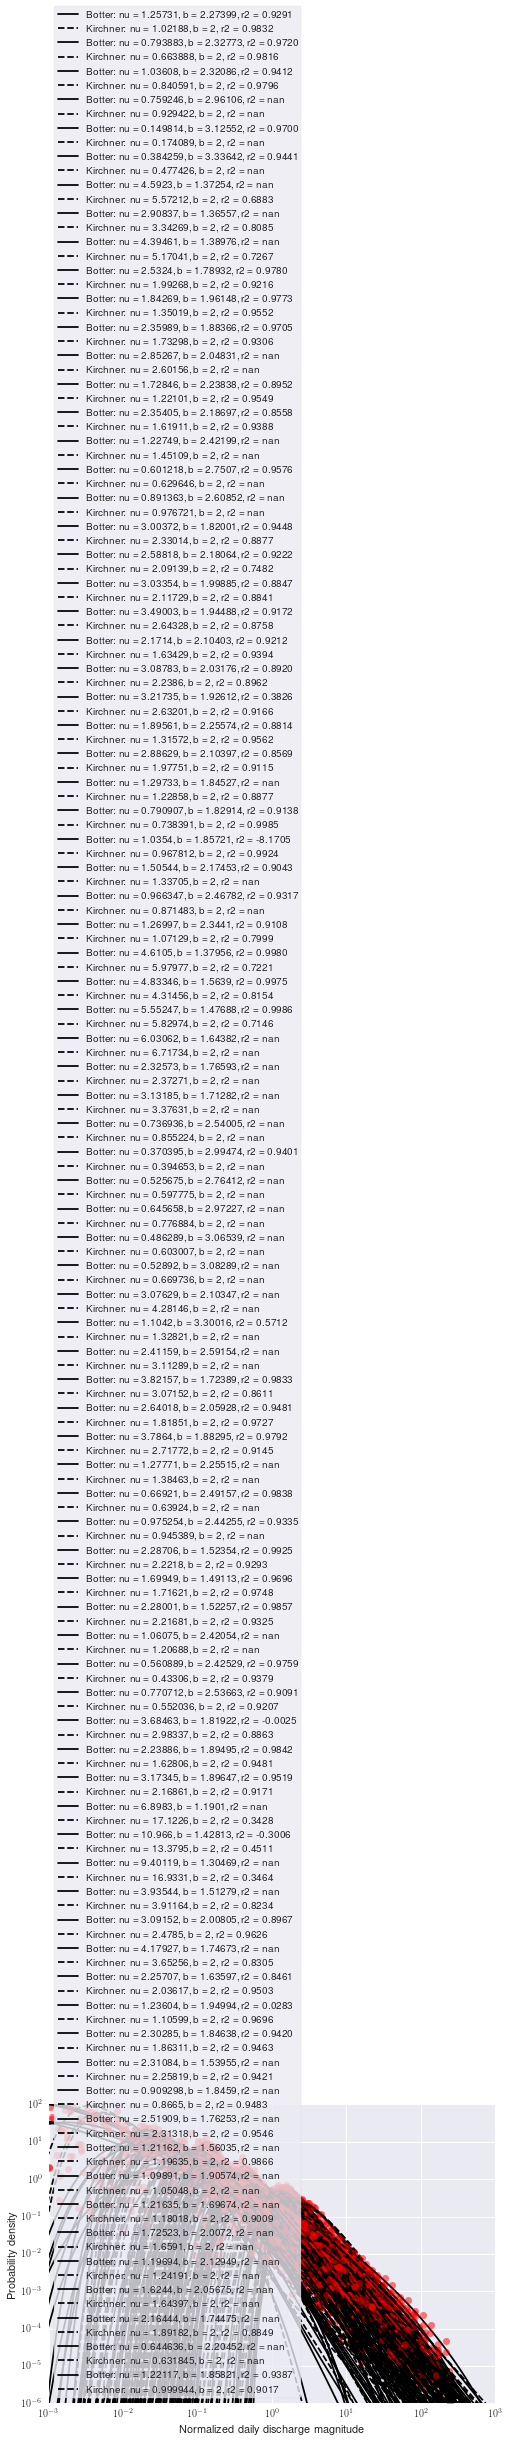

In [12]:
stationIDs = np.array([16103000, 16117000, 16130000, 16010000, 16049000, 16108000, 16116000, 16019000, 16036000, 16101000, 16115000, 16031000, 16047000, 16101003, 16114000, 16016000, 16037100, 16106000, 16013000, 16105000, 16017000, 16028000, 16031001, 16011000, 16012000, 16020000, 16021000, 16015000])

B_pdf_hat_t = {}
nu_hat_t = {}
nu_2_t = {}
fig, ax = plt.subplots(1)
for stationID in stationIDs:
    for season in ['wet', 'dry', 'yr']:
        fname = 'Kauai_discharge_txt/USGS%i_%s.txt' % (stationID, season)
        fname2 = 'USGS%i_%s' % (stationID, season)
        print(fname)
        df = pd.read_csv(fname, header=None)
        
        sample = df.values[:,0]
#         sample = sample[:1000]
#         sample = sample[sample<=sample.max()/2.]

        B_pdf_hat_t[fname2], nu_hat_t[fname2], B_pdf_bse, nu_bse, mu_t, b_r2 = pdf_fitter(sample, ax=ax)
        B, nu_2_t[fname2], B_pdf_bse, nu_bse, mu_t, b_r2 = pdf_fitter(sample, b=2., ax=ax)

In [174]:
from pdf_functions import *
count = 0
b_b  = np.zeros(84)
nu_b = np.zeros(84)
b_k  = np.zeros(84)
nu_k = np.zeros(84)
b_r2_b = np.zeros(84)
b_r2_k = np.zeros(84)
mu_k = np.zeros(84)
mu_b = np.zeros(84)
mu = np.zeros(84)
for stationID in stationIDs:
    for season in ['wet']:#, 'dry', 'yr']:
        fname2 = 'USGS%i_%s' % (stationID, season)
        b_b[count] = B_pdf_hat_t[fname2]
        nu_b[count] = nu_hat_t[fname2]
        b_k[count] = 2.
        nu_k[count] = nu_2_t[fname2]
        mu_b[count] = sample.mean()/C_mean(b_b[count], nu_b[count], 1, sample.max())
        mu_k[count] = sample.mean()/C_mean(b_k[count], nu_k[count], 1, sample.max())
        mu[count] = sample.mean()
        
        fname = 'Kauai_discharge_txt/USGS%i_%s.txt' % (stationID, season)
        df = pd.read_csv(fname, header=None)
        sample = df.values[:,0]
        
        sample_r2 = sample/sample.mean()
        Qe = np.percentile(sample_r2, range(1,100))
        q_r2 = np.logspace(np.log10(sample_r2.min()), np.log10(sample_r2.max()), 10000)
        pdfq_r2 = pdfq_calc(b_b[count], nu_b[count], 1)
        pdf_r2 = pdfq_r2(q_r2)
        X = sint.cumtrapz(pdf_r2,q_r2)
        Qt = np.zeros(99)
        for ii in range(1,100):
            try:
                idx = np.where(X>=ii/100.)[0][0]
                Qt[ii-1] = q_r2[idx]
            except:
                Qt[ii-1] = np.nan

        b_r2_b[count] = 1. - (np.nansum((Qt - Qe)**2) / np.nansum((Qe - Qe.mean())**2))
        
        sample_r2 = sample/sample.mean()
        Qe = np.percentile(sample_r2, range(1,100))
        q_r2 = np.logspace(np.log10(sample_r2.min()), np.log10(sample_r2.max()), 10000)
        pdfq_r2 = pdfq_calc(b_k[count], nu_k[count], 1)
        pdf_r2 = pdfq_r2(q_r2)
        X = sint.cumtrapz(pdf_r2,q_r2)
        Qt = np.zeros(99)
        for ii in range(1,100):
            try:
                idx = np.where(X>=ii/100.)[0][0]
                Qt[ii-1] = q_r2[idx]
            except:
                Qt[ii-1] = np.nan

        b_r2_k[count] = 1. - (np.nansum((Qt - Qe)**2) / np.nansum((Qe - Qe.mean())**2))

        count += 1

In [78]:
# np.isfinite(nu_b)

In [167]:

# sns.distplot(b_b)
# sns.jointplot(np.log10(nu_b), np.log10(nu_k), kind='kde')
# sns.distplot(nu_b/nu_k)
# plt.loglog(nu_b, nu_k, 'o')
# sns.jointplot(b_b, np.log10(nu_b))
# calculate r2 for fit distribution
count = 0


for stationID in stationIDs:
    for season in ['wet', 'dry', 'yr']:
#         fig = plt.figure(count, figsize=(5,4))
        fname = 'Kauai_discharge_txt/USGS%i_%s.txt' % (stationID, season)
        fname2 = 'USGS%i_%s' % (stationID, season)
        df = pd.read_csv(fname, header=None)
        sample = df.values[:,0]

        
        
#         pdf, x = pdf_ccdf(sample)
#         plt.loglog(x, pdf, 'ro', alpha=0.5)

#         pdfq = pdfq_calc(b_b[count], nu_b[count], sample.mean())
#         x = np.logspace(-5,5,1000)
#         plt.plot(x, pdfq(x), 'k--', label='Kirchner: nu = %g, b = %g, r2 = %0.4f' % (nu_b[count], b_b[count], b_r2_b[count]))

#         pdfq = pdfq_calc(b_k[count], nu_k[count], sample.mean())
#         x = np.logspace(-5,5,1000)
#         plt.plot(x, pdfq(x), 'k-', label='Botter: nu = %g, b = %g, r2 = %0.4f' % (nu_k[count], b_k[count], b_r2_k[count]))

#         plt.xlabel('Normalized daily discharge magnitude')
#         plt.ylabel('Probability density')
#         plt.legend(frameon=True, fancybox=True, loc=0)
#         plt.ylim(1e-6, 1e3)
#         plt.xlim(1e-4, 1e3)
        count += 1
#         plt.savefig(fname2+'.png', dpi=100)

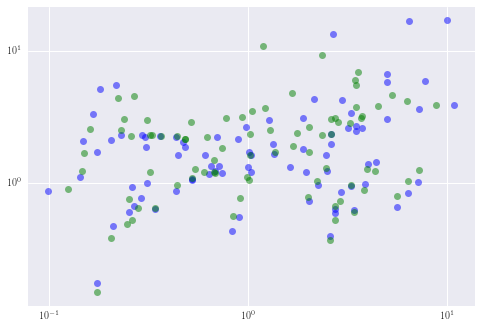

In [173]:
# sns.jointplot(np.log10(nu_b), np.log10(nu_k), kind='kde')
# plt.plot(b_b, nu_b/nu_k, 'o')
# plt.xlim(1,3)
# sns.distplot(np.log10(nu_k[b_r2_b>0.9]), label='kirchner')
# sns.distplot(np.log10(nu_b[b_r2_b>0.9]), label='botter')
# sns.jointplot(b_b[b_r2_b>0.9], nu_b[b_r2_b>0.9]/nu_k[b_r2_b>0.9])
# plt.ylim(0,8)
# print(b_r2_b.sum(), b_r2_k.sum())
plt.loglog(mu_k, nu_k, 'bo', alpha=0.5)
plt.loglog(mu_b, nu_b, 'go', alpha=0.5)
# plt.loglog(mu_k, mu, 'ro')
# plt.loglog(mu_b, mu, 'go')